***Done by:***<br>

**ELMESSAI Chaima**

In [ ]:
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import time
from river import metrics, utils
from river.stream import iter_pandas
from river import preprocessing
from river import optim
# Importing models that we are going to test 
from river.naive_bayes import GaussianNB, ComplementNB
from river import multiclass
from river import linear_model
from river.tree import ExtremelyFastDecisionTreeClassifier,HoeffdingTreeClassifier
from river import ensemble
from river import neighbors


# I- Importing covertype dataset:

* For a better visualization of the covertype dataset that we are going to use, we will convert the csv_file to a pandas dataframe having 54 feature columns and one label output column.We will define X as the features data frame and Y as the output dataframe. The names of each of the columns is fixed according to the discribtion of the dataset.<br>
* X and Y will be then converted to stream data using the function river.stream.iter_pandas.


In [ ]:
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
           'Horizontal_Distance_To_Roadways','Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'] + [f'Wilderness_Area{i}' for i in range(1, 5)] + [f'Soil_Type{i}'for i in range(1, 41)]+['Cover_Type']

coverType_df= pd.read_csv("./covtype.data", header=None, names = columns)
for i in range(1,5):
  coverType_df['Wilderness_Area'+str(i)] = coverType_df['Wilderness_Area'+str(i)].astype(int)
for i in range(1,41):
  coverType_df['Soil_Type'+str(i)] = coverType_df['Soil_Type'+str(i)].astype(int)

output_col = coverType_df.columns[-1]
features_cols = list(coverType_df.columns)
features_cols.pop()
X = coverType_df[features_cols]
Y = coverType_df[output_col].astype(int)

In [ ]:
coverType_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [ ]:
coverType_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

# II- Evaluation:

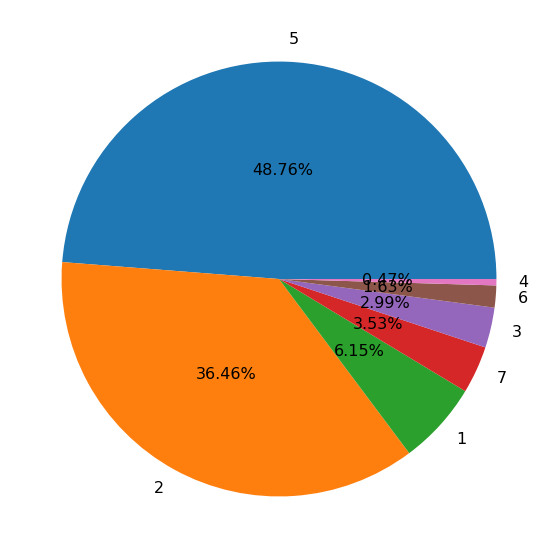

In [ ]:
pie, ax = plt.subplots(figsize=[15,10])
plt.pie(x = Y.value_counts(), autopct='%.2f%%', labels=list(Y.unique().astype('str')), pctdistance=0.5, textprops={'fontsize': 16})
plt.show()

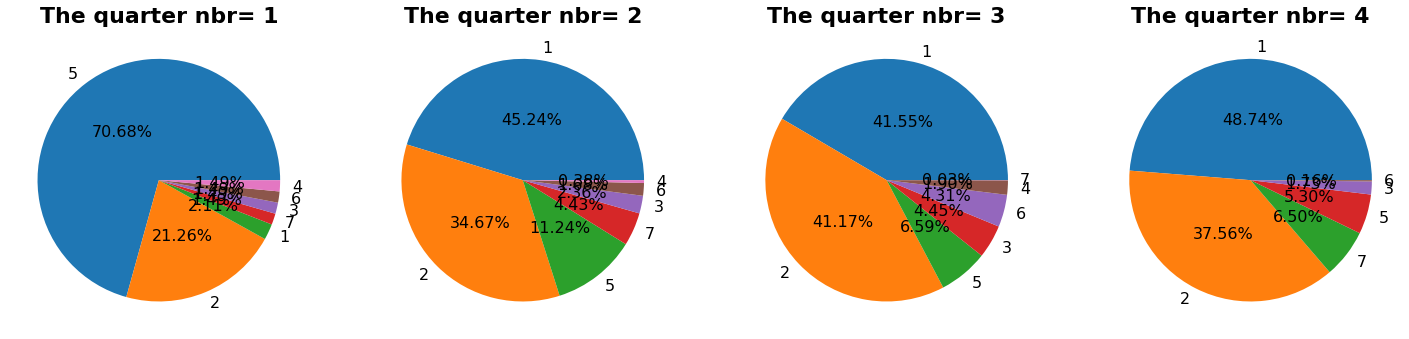

In [ ]:
n = int(Y.shape[0] /4)
pie, ax = plt.subplots(1,4, figsize=(25,25))
for i in range(1,5):
  data = Y[(i-1) * n : i* n]
  ax[i-1].pie(x = data.value_counts(), autopct='%.2f%%', labels=list(data.unique().astype('str')), pctdistance=0.5, textprops={'fontsize': 16})
  ax[i-1].set_title('The quarter nbr= '+str(i), fontsize=22, fontweight='bold')

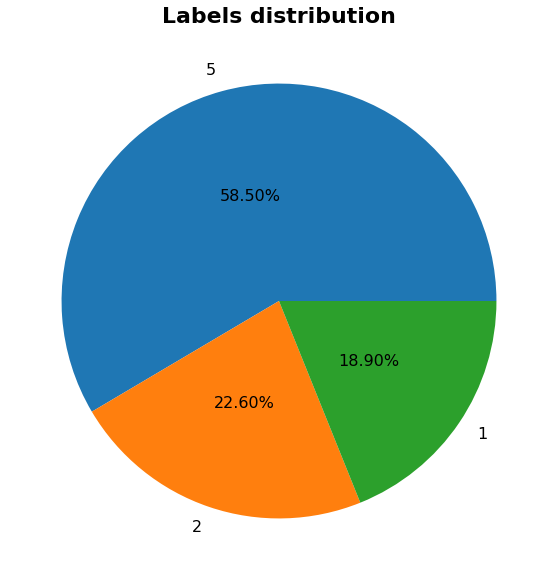

In [ ]:
pie, ax = plt.subplots(figsize=[15,10])
plt.pie(x = Y[:1000].value_counts(), autopct='%.2f%%', labels=list(Y[:1000].unique().astype('str')), pctdistance=0.5, textprops={'fontsize': 16})
plt.title('Labels distribution', fontsize=22, fontweight='bold')
plt.show()

In [ ]:
def print_progress(sample_id, balanced_acc,f1, kappa):
    print(f'Samples processed: {sample_id}')
    print(balanced_acc)
    print(f1)
    print(kappa)

def evaluate(stream, model, n_wait=1000, verbose=False):
    balanced_acc = metrics.BalancedAccuracy()
    balanced_acc_roll = utils.Rolling(metrics.BalancedAccuracy(), window_size=n_wait)
    f1 = metrics.WeightedF1()
    f1_roll = utils.Rolling(metrics.WeightedF1(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        # Predict
        start_test_time = time.time()
        y_pred = model.predict_one(x)
        end_test_time = time.time()
        test_time = end_test_time - start_test_time
        # Update metrics and results
        balanced_acc.update(y, y_pred)
        balanced_acc_roll.update(y, y_pred)
        f1.update(y, y_pred)
        f1_roll.update(y, y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        # Learn (train)
        start_train_time = time.time()
        model.learn_one(x, y)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time 
        if i % n_wait == 0 and i > 0:
          if verbose:
              print_progress(i, balanced_acc, f1, kappa)
          raw_results.append([model_name, i, balanced_acc.get(), balanced_acc_roll.get(), f1.get(), f1_roll.get(), kappa.get(), kappa_rolling.get(), test_time, train_time])
    print_progress(i, balanced_acc, f1, kappa)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'balanced_acc', 'balanced_acc_roll', 'f1', 'f1_roll','kappa', 'kappa_roll', 'test_time', 'train_time'])

## 1- Multiclass
 

In [ ]:
log_regr_one_vs_one = preprocessing.StandardScaler() | multiclass.OneVsOneClassifier(linear_model.LogisticRegression(optimizer=optim.SGD(0.1)))
logReg_one_vs_one_results = evaluate(stream=iter_pandas(X,Y),model=log_regr_one_vs_one)

Samples processed: 581011
BalancedAccuracy: 76.31%
WeightedF1: 92.04%
CohenKappa: 87.22%


## 2- Naive Bayes 

In [ ]:
gnb = GaussianNB()
gnb_results = evaluate(stream=iter_pandas(X,Y),model=gnb)

Samples processed: 581011
BalancedAccuracy: 12.56%
WeightedF1: 32.03%
CohenKappa: 0.04%


# 3- KNNClassifier

In [ ]:
knn = neighbors.KNNClassifier(window_size=30)
knn_results = evaluate(stream=iter_pandas(X,Y),model=knn)

Samples processed: 581011
BalancedAccuracy: 77.97%
WeightedF1: 94.91%
CohenKappa: 91.83%


# 4- HoeffdingTreeClassifier 

In [ ]:
Hoef_tree = HoeffdingTreeClassifier()
Hoef_tree_results = evaluate(stream=iter_pandas(X, Y),model=Hoef_tree)

Samples processed: 581011
BalancedAccuracy: 50.90%
WeightedF1: 75.64%
CohenKappa: 60.99%


# 5 - Ensemble methods

## 5.1 - AdaptiveRandomForestClassifier

In [ ]:
RF = ensemble.AdaptiveRandomForestClassifier(seed=0)
RF_results = evaluate(stream=iter_pandas(X,Y),model=RF)

Samples processed: 581011
BalancedAccuracy: 63.76%
WeightedF1: 86.93%
CohenKappa: 79.07%


# 5.2 AdaBoostClassifier

In [ ]:
adaboost = ensemble.AdaBoostClassifier(model=( HoeffdingTreeClassifier(split_criterion='gini',delta=1e-5,grace_period=2000)),n_models=5,seed=0)
adaboost_results = evaluate(stream=iter_pandas(X,Y),model=adaboost)

Samples processed: 581011
BalancedAccuracy: 61.04%
WeightedF1: 82.73%
CohenKappa: 72.21%


# III- Results visualization 

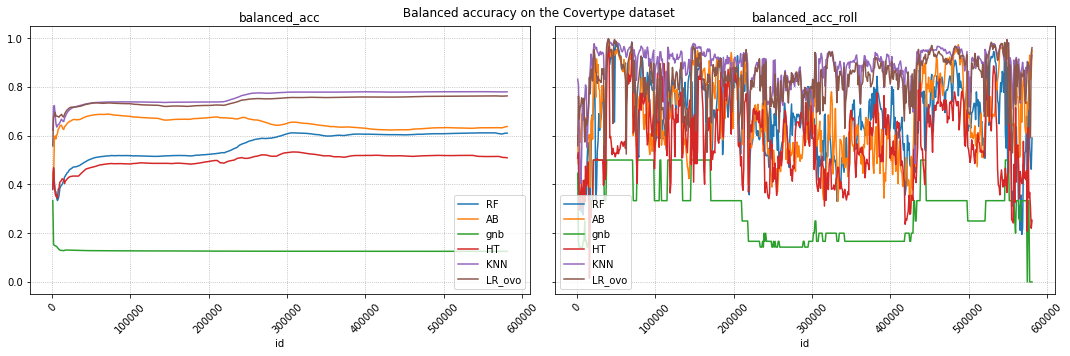

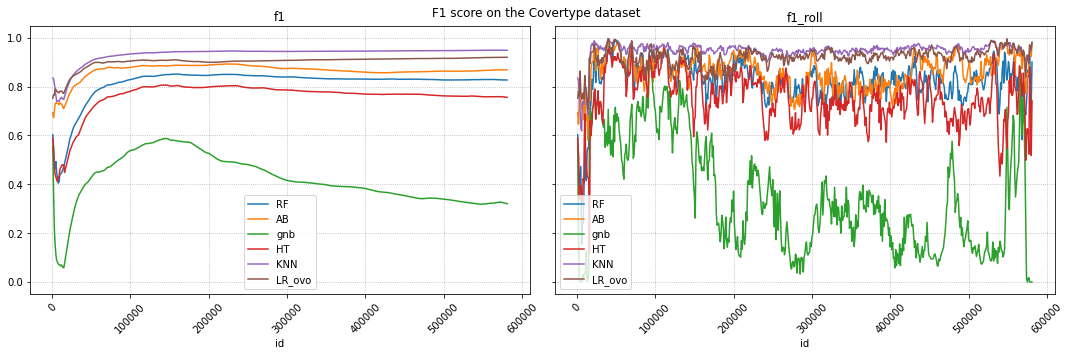

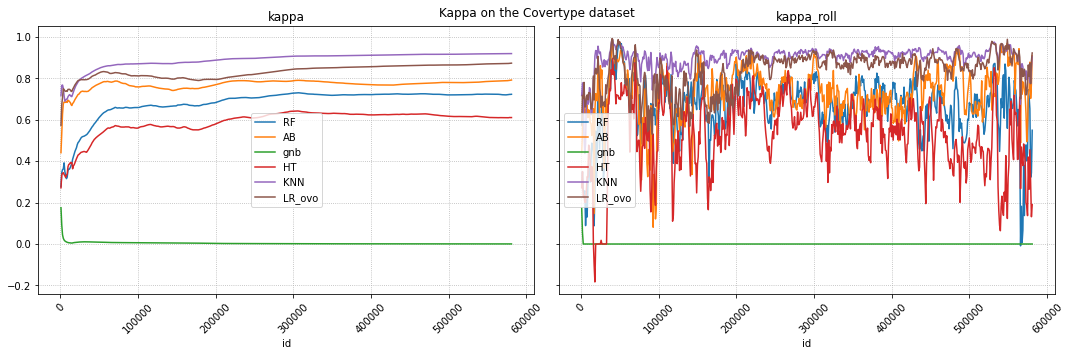

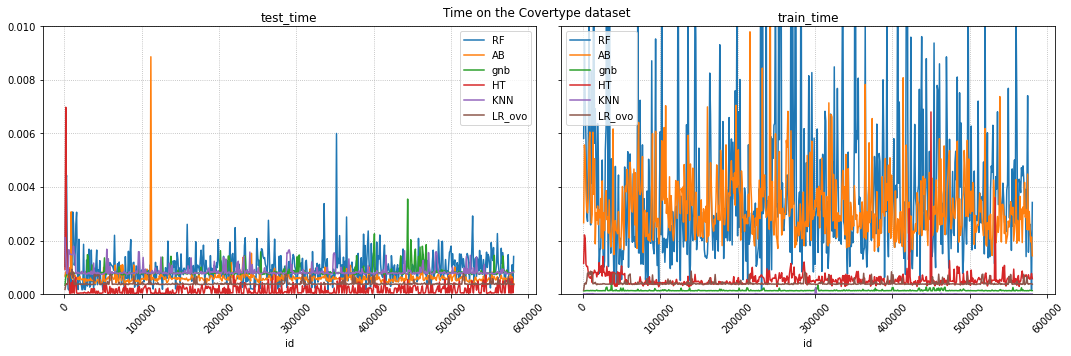

In [ ]:
dataset = "Covertype"
df = pd.concat([RF_results, adaboost_results,gnb_results,Hoef_tree_results,knn_results,logReg_one_vs_one_results])
df.set_index('id', inplace=True)
grouped = df.groupby('model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['balanced_acc', 'balanced_acc_roll'], axes.flatten()):
        grouped[metric].plot(rot=45,title=metric, legend=True, ax=ax)
        ax.legend(["RF","AB","gnb","HT","KNN","LR_ovo"],loc="best")
        ax.grid(linestyle=':')
    fig.suptitle(" Balanced accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['f1', 'f1_roll'], axes.flatten()):
        grouped[metric].plot(rot=45,title=metric, legend=True, ax=ax)
        ax.legend(["RF","AB","gnb","HT","KNN","LR_ovo"],loc="best")
        ax.grid(linestyle=':')
    fig.suptitle("F1 score on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['kappa', 'kappa_roll'], axes.flatten()):
        grouped[metric].plot(rot=45,title=metric, legend=True, ax=ax)
        ax.legend(["RF","AB","gnb","HT","KNN","LR_ovo"],loc="best")
        ax.grid(linestyle=':')
    fig.suptitle("Kappa on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['test_time', 'train_time'], axes.flatten()):
        grouped[metric].plot(rot=45,title=metric, legend=True, ax=ax)
        ax.legend(["RF","AB","gnb","HT","KNN","LR_ovo"],loc="best")
        ax.grid(linestyle=':')
        ax.set_ylim(0, 0.01)
    fig.suptitle("Time on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

In [ ]:
classifiers_average_time = []
results_array = np.array([logReg_one_vs_one_results,gnb_results,knn_results,Hoef_tree_results,RF_results, adaboost_results])
d={}
for i in range(6):
  metrics_i=results_array[i,:]
  train_time_i = metrics_i[:,8]
  test_time_i = metrics_i[:,9]
  execution_time_i = train_time_i + test_time_i
  average_execution_time_i = np.average(execution_time_i)
  classifiers_average_time.append(average_execution_time_i)

d={'logReg_one_vs_one':classifiers_average_time[0], 'gnb':classifiers_average_time[1],'knn':classifiers_average_time[2],'HT':classifiers_average_time[3],'RF':classifiers_average_time[4],'AdaBoost':classifiers_average_time[5]}

In [ ]:
print("Average of execution time for each of the classifiers : ")
print(d)

Average of execution time for each of the classifiers : 
{'logReg_one_vs_one': 0.0008114196757646518, 'gnb': 0.0009763047945478903, 'knn': 0.0008604973811085581, 'HT': 0.0007295025810727565, 'RF': 0.0039060165057289006, 'AdaBoost': 0.004994996443467788}
